Initializing eigensolver data
Computing 1 bands with 1e-09 tolerance
Working in 3 dimensions.
Grid size is 1 x 1280 x 1280.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,-0.5125,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0.5125,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 1 and 2 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zoddyodd.
Initializing fields to random numbers...
1 k-points
  Vector3<0.5, 0.0, 0.0>
elapsed time for initialization: 0.42600011825561523
solve_kpoint (0.5,0,0):
zoddyoddfreqs:, k index, k1, k2, k3, kmag/2pi, zoddyodd band 1
Solving for bands 1 

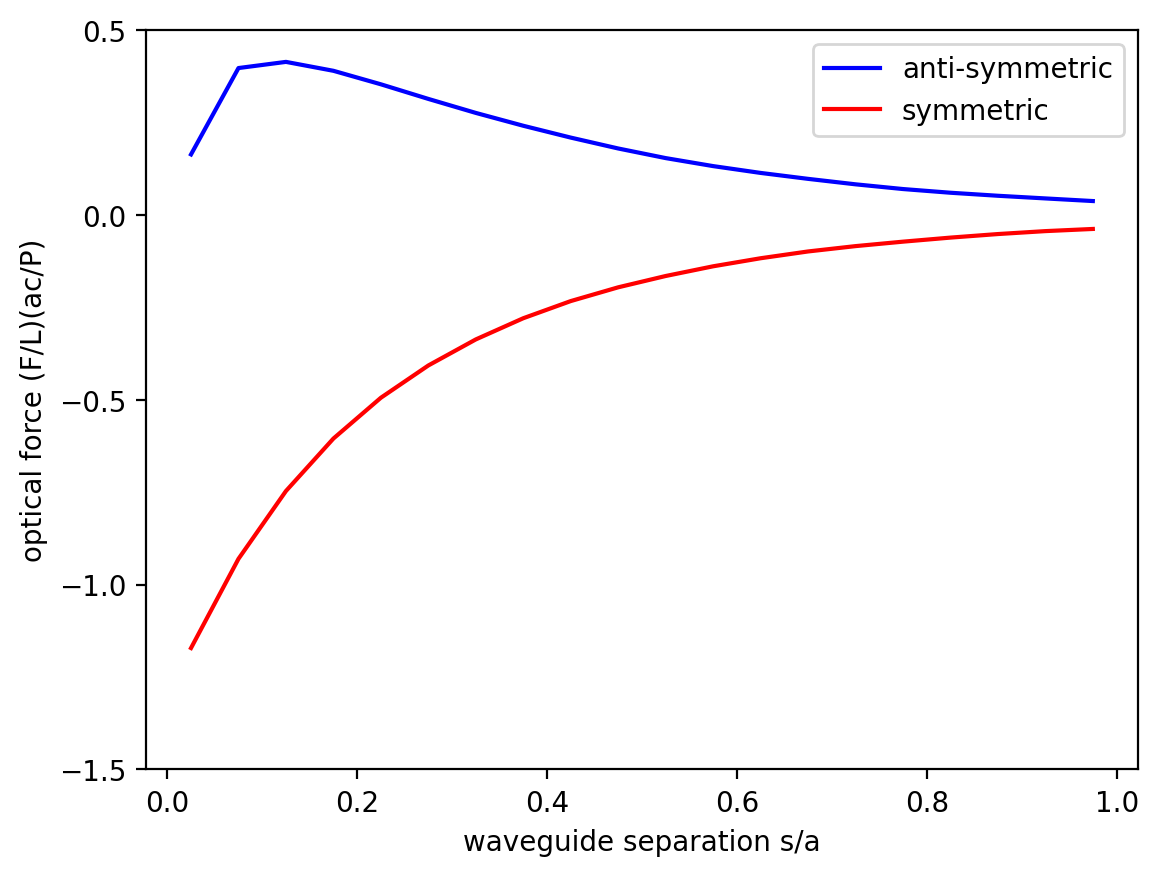

In [1]:
import meep as mp
from meep import mpb
import numpy as np
import matplotlib.pyplot as plt

resolution = 128  # pixels/μm

Si = mp.Medium(index=3.45)

syz = 10
geometry_lattice = mp.Lattice(size=mp.Vector3(0,syz,syz))

k_points = [mp.Vector3(0.5)]

a = 1.0  # waveguide width

def parallel_waveguide(s,yodd):
    geometry = [mp.Block(center=mp.Vector3(0,-0.5*(s+a),0),
                         size=mp.Vector3(mp.inf,a,a),
                         material=Si),
                mp.Block(center=mp.Vector3(0,0.5*(s+a),0),
                         size=mp.Vector3(mp.inf,a,a),
                         material=Si)]

    ms = mpb.ModeSolver(resolution=resolution,
                        k_points=k_points,
                        geometry_lattice=geometry_lattice,
                        geometry=geometry,
                        num_bands=1,
                        tolerance=1e-9)

    if yodd:
        ms.run_yodd_zodd()
    else:
        ms.run_yeven_zodd()

    f = ms.get_freqs()[0]
    vg = ms.compute_group_velocity_component(mp.Vector3(1,0,0))[0]

    return f,vg

ss = np.arange(0.025,1.075,0.05)

f_odd = np.zeros(len(ss))
vg_odd = np.zeros(len(ss))
f_even = np.zeros(len(ss))
vg_even = np.zeros(len(ss))

for j in range(len(ss)):
    f_odd[j], vg_odd[j] = parallel_waveguide(ss[j],True)
    f_even[j], vg_even[j] = parallel_waveguide(ss[j],False)

ds = ss[1]-ss[0]

def compute_force(f,vg):
    f_avg = 0.5*(f[:-1]+f[1:])
    df = f[1:]-f[:-1]
    vg_avg = 0.5*(vg[:-1]+vg[1:])
    return -1/f_avg * df/ds * 1/vg_avg

force_odd = compute_force(f_odd,vg_odd)
force_even = compute_force(f_even,vg_even)

plt.figure(dpi=200)
plt.plot(ss[:-1],force_odd,'b-',label='anti-symmetric')
plt.plot(ss[:-1],force_even,'r-',label='symmetric')
plt.xlabel("waveguide separation s/a")
plt.ylabel("optical force (F/L)(ac/P)")
plt.legend(loc='upper right')
plt.xticks(np.arange(0,1.2,0.2))
plt.yticks(np.arange(-1.5,1.0,0.5))
plt.show()